#  Прогнозирование заказов на следующий час

Компания собрала исторические данные о заказах. Нужно спрогнозировать количество заказов на следующий час. 

Цель проекта: Построить модель для предсказания количества заказов на следующий час.

Задача: Построить модель со значением метрики *RMSE* на тестовой выборке - не больше 48.

Для решения поставленной задачи необходимо выполнить следующие шаги:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Выделить тестовую выборку размером 10% от исходных данных. Обучить разные модели с различными гиперпараметрами. 
4. Проверить данные на тестовой выборке.

## Подготовка

In [16]:
import pandas as pd
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

Загрузим и изучим данные.

In [17]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Датафрейм содержит 26 496 строк и один столбец. Выполним ресемплирование датасета по одному часу.

In [18]:
taxi.sort_index(inplace=True)
taxi = taxi.resample('1H').sum()
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Вывод: загрузили и изучили данные. Первоначально датафрейм содержал 26 496 строк и один столбец. После выполнения ресемплирование датасета по одному часу, количество строк сократилось до 4 416. 

## Анализ

Посмотрим, как датафрейм выглядит графически.

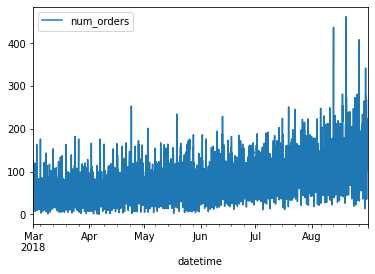

In [19]:
taxi.plot()
plt.show()

Чтобы лучше понять временной ряд, разложим его на тренды и сезонную компоненту.

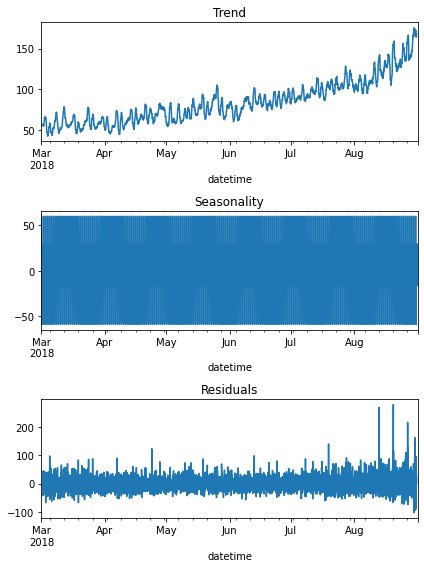

In [20]:
decomposed = seasonal_decompose(taxi)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Мы видим, что с марта по апрель 2018 года количество заказов постоянно увеличивалось. Посмотрим данные за один месяц, чтобы лучше понять сезонность.

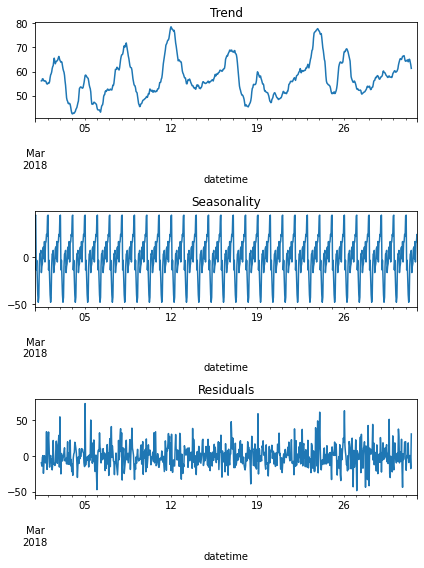

In [21]:
taxi_month = taxi['2018-03-01':'2018-03-31'].resample('1H').sum()
taxi_month_decomposed = seasonal_decompose(taxi_month)

plt.figure(figsize=(6, 8))
plt.subplot(311)
taxi_month_decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
taxi_month_decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
taxi_month_decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Видим, что сезонность лучше отследить на ещё более мелких диапазонах. Возьмем пару дней. 

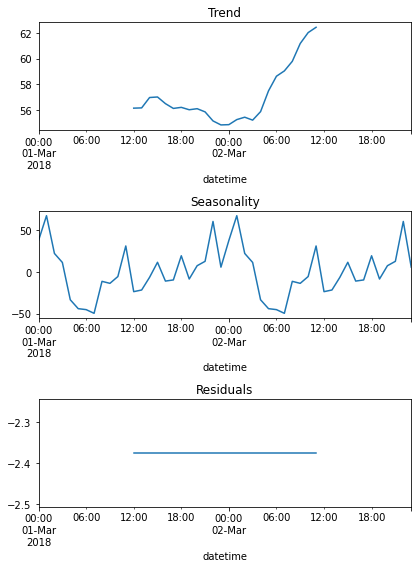

In [22]:
taxi_day1 = taxi['2018-03-01':'2018-03-02'].resample('1H').sum()
taxi_day1_decomposed = seasonal_decompose(taxi_day1)

plt.figure(figsize=(6, 8))
plt.subplot(311)
taxi_day1_decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
taxi_day1_decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
taxi_day1_decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Мы видим, что пик активности приходится на ночное время, примерно с 10 до 01 часов.

Также мы видим, что в августе было несколько аномально высоких значений.

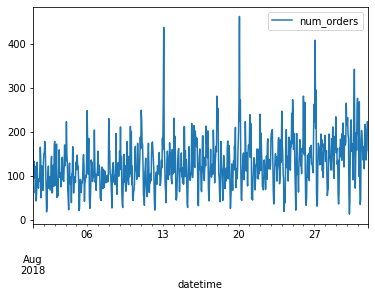

In [23]:
taxi['2018-08-01':'2018-08-31'].plot()
plt.show()

Уменьшим эти выбросы до уровня максимальных значений остальных данных за август.

In [24]:
taxi[taxi['num_orders']>300] = 300

Вывод: Чтобы лучше понять временной ряд, разложили его на тренды и сезонную компоненту. Определили, что с марта по апрель 2018 года количество заказов постоянно увеличивалось, а пик суточной активности приходится на ночное время, примерно с 10 часов до 01 часа.

## Обучение

Обучим разные типы моделей. Для этого разобьем данные на три выборки.

In [25]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(taxi, 24, 3)

train, test_valid = train_test_split(taxi, shuffle=False, test_size=0.2)
valid, test = train_test_split(test_valid, shuffle=False, test_size=0.5)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
features_test = test.drop(['num_orders'], axis=1)
features_valid = valid.drop(['num_orders'], axis=1)
target_train = train['num_orders']
target_test = test['num_orders']
target_valid = valid['num_orders']

Сначала обучим модель CatBoost.

In [26]:
best_model1 = None
best_result1 = 70

for i in range(100, 300, 50):
    model_CatBoost = CatBoostRegressor(iterations=i)
    model_CatBoost.fit(features_train, target_train, verbose=1000)
    probabilities_valid = model_CatBoost.predict(features_valid)
    MSE = mean_squared_error(target_valid, probabilities_valid)
    RMSE = math.sqrt(MSE)
    if RMSE < best_result1:
        best_model1 = model_CatBoost
        best_result1 = RMSE
        best = i

print(best_model1)
print(best_result1)
print(i)

Learning rate set to 0.324563
0:	learn: 31.0123757	total: 9.7ms	remaining: 960ms
99:	learn: 13.2363752	total: 585ms	remaining: 0us
Learning rate set to 0.233419
0:	learn: 32.2217344	total: 7.72ms	remaining: 1.15s
149:	learn: 12.5701706	total: 855ms	remaining: 0us
Learning rate set to 0.18474
0:	learn: 32.9075703	total: 8.84ms	remaining: 1.76s
199:	learn: 12.2192654	total: 1.38s	remaining: 0us
Learning rate set to 0.15409
0:	learn: 33.3526468	total: 7.34ms	remaining: 1.83s
249:	learn: 11.8339527	total: 1.55s	remaining: 0us
30.276212595042058
250


RMSE модели CatBoost = 30,3.

Далее обучим модель LGBMRegressor.

In [27]:
best_model2 = None
best_result2 = 70

for n in range(3, 10):
    model = LGBMRegressor(n_estimators=n, random_state=12345)
    model.fit(features_train, target_train)
    probabilities_valid = model.predict(features_valid)
    MSE = mean_squared_error(target_valid, probabilities_valid)
    RMSE = math.sqrt(MSE)
    if RMSE < best_result2:
        best_model2 = model
        best_result2 = RMSE

print(best_model2)
print(best_result2)

LGBMRegressor(n_estimators=9, random_state=12345)
40.092281781274416


RMSE модели LGBMRegressor = 40,1.

И, наконец, обучим модель "Случайный лес в регрессии".

In [28]:
best_model3 = None
best_result3 = 70
best_n = 0
best_depth = 0
for n in range(3, 10):
    for depth in range (2, 7):
        model = RandomForestRegressor(random_state=12345, n_estimators=n, max_depth=depth) 
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        MSE = mean_squared_error(target_valid, predictions_valid)
        RMSE = math.sqrt(MSE)
        if RMSE < best_result3:
            best_model3 = model
            best_result3 = RMSE
            
print(best_model3)
print(best_result3)

RandomForestRegressor(max_depth=6, n_estimators=9, random_state=12345)
34.793563973880076


RMSE модели "Случайный лес в регрессии" = 34,8.

Соберем все данные в одну таблицу.

In [29]:
analis = {'Название модели': ['CatBoost', 'LGBMRegressor', 'Случайный лес в регрессии'], 
          'RMSE': [best_result1, best_result2, best_result3]}
best_model= pd.DataFrame(analis)
display(best_model)

Название модели       RMSE
0                   CatBoost  30.276213
1              LGBMRegressor  40.092282
2  Случайный лес в регрессии  34.793564

Лучший результат показала модель CatBoost.

Вывод: обучили разные типы моделей. RMSE модели CatBoost = 30,1. RMSE модели LGBMRegressor = 40,1. RMSE модели "Случайный лес в регрессии" = 34,8. Лучший результат показала модель CatBoost.

## Тестирование

Проверим работу модели CatBoost на тестовых данных.

In [30]:
model_CatBoost = CatBoostRegressor(iterations=650)
model_CatBoost.fit(features_train, target_train, verbose=1000)
probabilities = model_CatBoost.predict(features_test)
MSE = mean_squared_error(target_test, probabilities)
RMSE = math.sqrt(MSE)
    
print(RMSE)

Learning rate set to 0.07086
0:	learn: 34.6093569	total: 6.25ms	remaining: 4.06s
649:	learn: 10.9410251	total: 4.3s	remaining: 0us
47.971128211935664


RMSE модели CatBoost на тестовых данных равно 47.97, что соответствует поставленной задаче.

### Общий вывод: ###
    
Мы загрузили и изучили данные. 

Разложили временной ряд на тренды и сезонную компоненту. Определили, что с марта по апрель 2018 года количество заказов постоянно увеличивалось, а пик суточной активности приходится на ночное время, примерно с 10 часов до 01 часа.

Обучили разные типы моделей. Лучший результат показала модель CatBoost.

RMSE модели CatBoost на тестовых данных равно 47.97, что соответствует поставленной задаче.